# Assignment 3: Neural Network By Hand!

We want our neural network to solve the XOR problem.

# Part 1: Derivation of Backpropagation

- Notation :
             s : sample index
             S : total number of samples
             c : layer number
             v : number of features

At the last layer :

$$\frac{\partial Cost}{\partial W^{c}} = \frac{1}{S}  Σ_{s=1}^{S} a^{(s,c-1)}[f^{'}(z^{(s,c)}) ⊙ L^{'}(a^{(s,c)},y^{(s)})]^{T}$$

$$\delta^{(s,c)} = f^{'}(z^{(s,c)}) \odot L^{'}(a^{(s,c)},y^{(s)})$$

For every layer:
$$\frac{\partial Cost}{\partial W^{c}} =\frac{1}{S}  \Sigma_{s=1}^{S} a^{(s,c-1)}[\delta^{(s,c)}]^T$$

Find the demonstration in the attached <font color="#E83E8C"> .pdf </font> file of the same name.

# Part 2: Code it!



## Setup

In [ ]:
# Useful imports and helpers provided in the assignment #

import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
  output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
  ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Cost")
  ax.legend(loc="upper right", frameon=False)
  ax.set_title(title)
  plt.show()


def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))

  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title)
  plt.show()

## 1. Get the data

### 1.1: Get the data file

In [ ]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# path to the file on Google Drive
folder = "/content/gdrive/MyDrive/aims_2425/intro_ml/assignments/ml_a3/"

train_set = pd.read_csv(folder + "ml_a3_data_train.csv")
test_set = pd.read_csv(folder + "ml_a3_data_test.csv")

- How many samples are there in each? Write a full sentence to express your answer.

> There are `320 samples ` in the `train` set and `80 samples` in the `test` set.

- What is the name of the column containing the labels? What are the class values?

> The name of the column containing the labels is `class`, the values for the class are `0` or `1`.

In [ ]:
print(f"There are {train_set.shape[0]} samples in the train set and {test_set.shape[0]} samples in the test set ")
print(f"The dataset contains {train_set.shape[1]} columns : {train_set.columns}")
print(f"The class values are : {train_set['class'].unique()}")

train_set.head()

There are 320 samples in the train set and 80 samples in the test set 
The dataset contains 3 columns : Index(['x1', 'x2', 'class'], dtype='object')
The class values are : [0 1]


,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0


### 1.2: Split signal vs background

In [ ]:
# split signal and background for the train set
sig_train = train_set[train_set['class'] == 1]
bkg_train = train_set[train_set['class'] == 0]

# split signal and background for the test set
sig_test = test_set[test_set['class'] == 1]
bkg_test = test_set[test_set['class'] == 0]

### 1.3: Dataframe to NumPy

In [ ]:
# the input features that will be used
inputs = ['x1', 'x2']

# X_train to contain the input features as numpy array
# y_train to contain the target as numpy array
X_train = train_set[inputs].to_numpy()
y_train = train_set["class"].to_numpy()

# same process for the test
X_test = test_set[inputs].to_numpy()
y_test = test_set["class"].to_numpy()

## 2. Functions

### 2.1: Weighted Sum

In [ ]:
# weighted performed as matrix operations : multiplication and addition
def z( weights , inputs , biases ):
    return (weights.T)@inputs+biases

### 2.2: Activation Functions and Derivatives

In [ ]:
# hypebolic tangent : activation function of the 2 hidden layers
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

# sigmoid : activation function of the last layer
def sigmoid(z):
    return 1/(1+np.exp(-z))

# derivative of the sigmoid
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

# derivative of the tanh function
def tanh_prime(z):
    return 1-(tanh(z)**2)

### 2.3: Cross-entropy cost function

In [ ]:
# compute the cost function
def cross_entropy_cost(y_preds, y_vals):
    losses = y_vals*np.log(y_preds)+(1-y_vals)*np.log(1-y_preds)
    return (-1/y_preds.shape[0])*np.sum(losses)

### 2.4: Derivative of the Loss

Loss function for classification is defined as :

$$L(\hat y^{(i)},y) = -[y^{(i)} log(\hat y^{(i)})+(1-y^{(i)}) log(1 - \hat y^{(i)})]$$

The derivative of that function is :
$$\frac{d L(\hat y^{(i)},y)}{d \hat y^{(i)}} = -[y^{(i)} \frac{d(log(\hat y^{(i)}))}{d \hat y^{(i)}} +(1-y^{(i)}) \frac{d(log(1 - \hat y^{(i)}))}{d \hat y^{(i)}}] $$

$$\frac{d L(\hat y^{(i)},y)}{d \hat y^{(i)}} = -[y^{(i)} \frac{1}{\hat y^{(i)}} +(1-y^{(i)}) \frac{-1}{1- \hat y^{(i)}}] $$

$$\frac{d L(\hat y^{(i)},y)}{d \hat y^{(i)}} =  \frac{-y^{(i)}}{\hat y^{(i)}} + \frac{1-y^{(i)}}{1- \hat y^{(i)}} $$

In [ ]:
# compute the derivative of the loss function according to the formula above
def L_prime(y_preds, y_obs):
    return -(y_obs/y_preds)+((1-y_obs)/(1-y_preds))

## 3. Feedforward

### 3.1: Feedforward Propagation

In [ ]:
# compute the feed forward
def feedforward(input_X, weights, biases):

  W1, W2, W3 = weights ; b1, b2, b3 = biases

  m  = len(input_X)
  a0 = input_X.reshape ((m, -1, 1))

  # First layer
  z1 = z(W1,a0,b1)
  a1 = tanh(z1)

  # Second layer
  z2 = z(W2,a1,b2)
  a2 = tanh(z2)

  # Third layer
  z3 = z(W3,a2,b3)
  a3 = sigmoid(z3)

  nodes = [a0, z1, a1, z2, a2, z3, a3]

  return nodes

### 3.2: Predict

- What is the <font color="#E83E8C"> output_node </font> in the context of our 2-hidden-layered neural network?
> The **output node** is `a3`, its values range between 0 to 1 (as a result of the sigmoid function )

- What type of values does the function <font color="#E83E8C"> predict  </font> return?
> The **predict** function returns binary values : either 0 or 1

- After successfully executing the <font color="#E83E8C"> feedforward </font> function, how would you call the function <font color="#E83E8C"> predict </font> ?
> After successfully executing the feedforward, I will call predict passing the **output node** as argument :   

```python
output = feedforward(input_X, [W1,W2,W3], [b1,b2,b3])[-1] # getting only output node
predictions = predict(output, 0.5) # take boundary value as 0.5
```


## 4. Neural Network Training

In [ ]:
# Hyperparameters
alpha = 0.03
N = 10000 # epochs

# Initialization
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 3 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer

# sigmas to initialize the weights based on Normal Xavier initialization
sigma1,sigma2,sigma3 = np.sqrt(2/(n+q)), np.sqrt(2/(q+1+2)), np.sqrt(2/(r+2))
# WEIGHT MATRICES + BIASES
W1 =  np.random.normal(0,sigma1,size=(n,q)) # Xavier initialization
W2 =  np.random.normal(0,sigma2,size=(q,r))
W3 =  np.random.normal(0,sigma3,size=(r,1))
b1 =  np.random.randn(q , 1 ) # initialization from a normal distribution
b2 =  np.random.randn(r , 1 )
b3 =  np.random.randn(1 , 1 )


# OUTPUT LAYER
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []
debug = False

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for t in range(1, N+1):

  # FORWARD PROPAGATION
  # Feedforward on test data:
  nodes_test =  feedforward(X_test,[W1,W2,W3],[b1,b2,b3])
  ypreds_test =  nodes_test[-1]

  # Feedforward on train data:
  a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train,[W1,W2,W3],[b1,b2,b3])
  ypreds_train =  a3

  # Cost computation and storage
  J_train = cross_entropy_cost(ypreds_train, y_train)
  J_test  = cross_entropy_cost(ypreds_test,  y_test )
  costs_train.append(J_train)
  costs_test.append(J_test)

  if (t<=100 and t % 10 == 0) or (t>100 and t % 100 == 0):
      print(f"Iteration {t}\t Train cost = {J_train:.4f}  Test cost = {J_test:.4f}   Diff = {J_test-J_train:.5f}")


  # BACKWARD PROPAGATION
  # Errors delta:
  delta_3 = sigmoid_prime(z3) * L_prime(ypreds_train,y_train)
  delta_2 = tanh_prime(z2) * (W3@delta_3)
  delta_1 = tanh_prime(z1) * (W2@delta_2)

  # Partial derivatives:
  # np.transpose(delta, (0, 2, 1)) transposes delta to be able to perform the outer product : a*delta
  dCostdW3 = (1/m) * np.sum(a2@np.transpose(delta_3, (0, 2, 1)),axis=0)
  dCostdW2 = (1/m) * np.sum(a1@np.transpose(delta_2, (0, 2, 1)),axis=0)
  dCostdW1 = (1/m) * np.sum(a0@np.transpose(delta_1, (0, 2, 1)),axis=0)
  dCostdb3 = (1/m) * np.sum(delta_3,axis=0)
  dCostdb2 = (1/m) * np.sum(delta_2,axis=0)
  dCostdb1 = (1/m) * np.sum(delta_1,axis=0)

  if debug and t<3:
    print(f"a0: {a0.shape} a1: {a1.shape} a2: {a2.shape} a3: {a3.shape} ")
    print(f"W3: {W3.shape} z1: {z1.shape} z2: {z2.shape} z3: {z3.shape} ")
    print(f"dCostdW3: {dCostdW3.shape} dCostdW2: {dCostdW2.shape} dCostdW1: {dCostdW1.shape}")

  # Update of weights and biases
  W3 = W3 - alpha*dCostdW3
  W2 = W2 - alpha*dCostdW2
  W1 = W1 - alpha*dCostdW1
  b3 = b3 - alpha*dCostdb3
  b2 = b2 - alpha*dCostdb2
  b1 = b1 - alpha*dCostdb1

print(f'\nEnd of gradient descent after {t} iterations')

Starting the training

Iteration 10	 Train cost = 0.6981  Test cost = 0.7350   Diff = 0.03688
Iteration 20	 Train cost = 0.6915  Test cost = 0.7247   Diff = 0.03312
Iteration 30	 Train cost = 0.6855  Test cost = 0.7158   Diff = 0.03028
Iteration 40	 Train cost = 0.6795  Test cost = 0.7079   Diff = 0.02840
Iteration 50	 Train cost = 0.6730  Test cost = 0.7007   Diff = 0.02761
Iteration 60	 Train cost = 0.6654  Test cost = 0.6934   Diff = 0.02799
Iteration 70	 Train cost = 0.6566  Test cost = 0.6858   Diff = 0.02924
Iteration 80	 Train cost = 0.6473  Test cost = 0.6779   Diff = 0.03061
Iteration 90	 Train cost = 0.6383  Test cost = 0.6699   Diff = 0.03154
Iteration 100	 Train cost = 0.6301  Test cost = 0.6620   Diff = 0.03195
Iteration 200	 Train cost = 0.5642  Test cost = 0.5898   Diff = 0.02557
Iteration 300	 Train cost = 0.5035  Test cost = 0.5179   Diff = 0.01443
Iteration 400	 Train cost = 0.4419  Test cost = 0.4447   Diff = 0.00284
Iteration 500	 Train cost = 0.3860  Test cost = 0.

## 5. Plots

### 5.1: Cost evolution

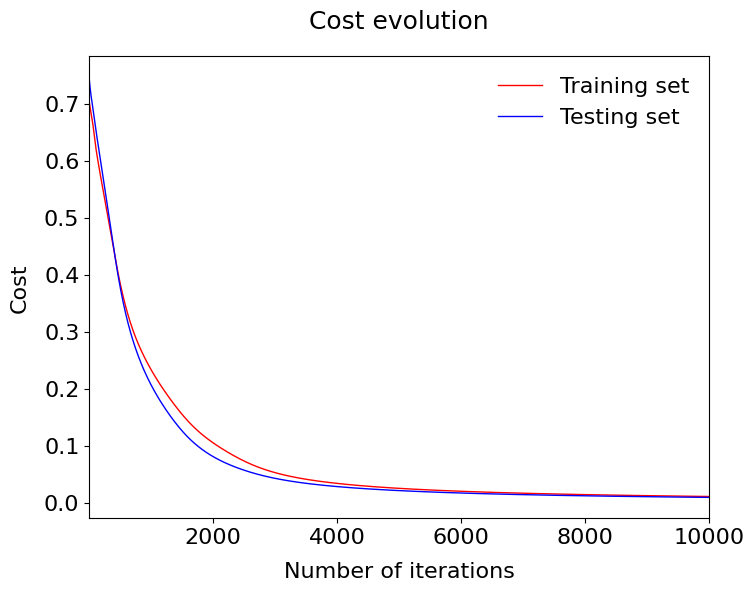

In [ ]:
# plot the cost evolution of both the training and the testing sets
plot_cost_vs_iter(costs_train,costs_test)

### 5.2: Scatter Plot

- Did your neural network successfully learn the XOR function?
> Yes, the neural network successfully learn the XOR function, it classifies well the distinct classes ( illustration below )

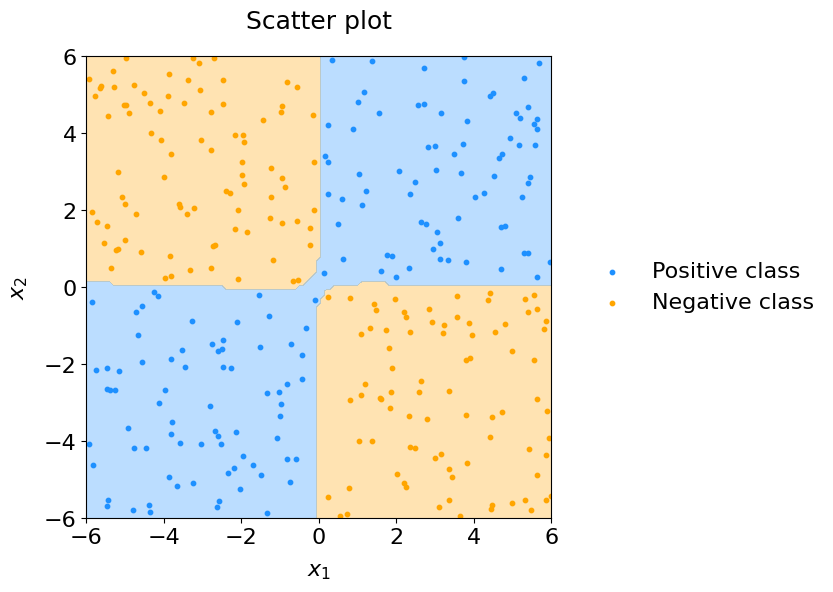

In [ ]:
# get the decision surface and then plot it with the scatter plot of the training data
ds = get_decision_surface(weights=[W1,W2,W3],biases=[b1,b2,b3])
plot_scatter(sig_train,bkg_train,ds=ds)

# BONUS

In this part, we create a general class to build fully connected neural networks. We will then test it on the same example.

In [ ]:
# CLASS FOR THE NEURAL NETWORK #
# wrap the logic above in a class for a more general fully connected neural networks #
# This class can still be improved (a lot) (example : adding predict function) but it is already handled outside here #

class NeuralNetwork():
  def __init__(self,n_inputs,n_outputs):
    self.weights = [] # store the different weights for the layers
    self.biases = [] # store the biases
    self.nodes = [] # store the number of nodes per layer
    self.act_funcs = [] # store the activation function per layer
    self.func_primes = [] # store the derivative of the activation function per layer
    self.n_inputs = n_inputs # number of features
    self.n_outputs = n_outputs # number of output nodes, what for ? checking below

  # process of adding a layer
  def add_layer(self,n_nodes,activation_func,func_prime):
    self.nodes.append(n_nodes) # how many nodes for that layer
    self.act_funcs.append(activation_func) # what is the activation function
    self.func_primes.append(func_prime) # what is the derivative of that activation function


  def forward(self,input_X):

    # outputs : outputs per layer, z_sums : weighted sums per layer
    outputs = []
    z_sums = []
    m  = len(input_X)
    a0 = input_X.reshape ((m, -1, 1))

    # process the input layer
    outputs.append(a0)
    z_sum = z(self.weights[0],a0,self.biases[0])
    output = self.act_funcs[0](z_sum)
    z_sums.append(z_sum)
    outputs.append(output)

    # process the other layers
    for idx in range(1,len(self.weights)):
      z_sum = z(self.weights[idx],output,self.biases[idx])
      output = self.act_funcs[idx](z_sum)
      z_sums.append(z_sum)
      outputs.append(output)

    return z_sums,outputs

  def initialize(self):
    # intiliaze the weights : Xavier initialization for the weights
    # the first hidden layer
    weight = np.random.normal(0,np.sqrt(2/(self.n_inputs+self.nodes[0])),size=(self.n_inputs,self.nodes[0]))
    bias =  np.random.randn(self.nodes[0] , 1 )
    self.weights.append(weight)
    self.biases.append(bias)

    # the other layers
    for idx in range(1,len(self.nodes)):
      weight = np.random.normal(0,np.sqrt(2/(self.nodes[idx-1]+self.nodes[idx]+1)),size=(self.nodes[idx-1],self.nodes[idx]))
      bias =  np.random.randn(self.nodes[idx] , 1 )
      self.weights.append(weight)
      self.biases.append(bias)

  def train(self,X_train,y_train,X_test,y_test,iterations=10000,learning_rate=0.03):

    # check in case the network is not well built
    if self.n_outputs != self.nodes[-1] :
      print("Network cannot be trained: number of output nodes does not match the last layer")
      return None

    # intialization
    self.initialize()

    costs_train = []
    costs_test  = []

    deltas = [0]*len(self.weights)
    dWs = [0]*len(self.weights)
    dbs = [0]*len(self.weights)

    print("Starting the training\n")

   # This part should be uncommented but the two vectors #
   # here is already reshaped in previous section so commented for this example #
   # y_train = np.reshape(y_train, (-1, 1, 1))
   # y_test  = np.reshape(y_test , (-1, 1, 1))

    for t in range(1,iterations+1):

      #print(f"start {t}")

      # FORWARD PROPAGATION
      # Feedforward on test data:
      _,out_test =  self.forward(X_test)
      ypreds_test =  out_test[-1]

      # Feedforward on train data:
      z_sums,out_train = self.forward(X_train)
      ypreds_train = out_train[-1]

      # Cost computation and storage
      J_train = cross_entropy_cost(ypreds_train, y_train)
      J_test  = cross_entropy_cost(ypreds_test,  y_test )
      costs_train.append(J_train)
      costs_test.append(J_test)


      if (t<=100 and t % 10 == 0) or (t>100 and t % 100 == 0):
        print(f"Iteration {t}\t Train cost = {J_train:.4f}  Test cost = {J_test:.4f}   Diff = {J_test-J_train:.5f}")

      # BACKWARD PROPAGATION
      # Errors delta:
      deltas[-1] = self.func_primes[-1](z_sums[-1]) * L_prime(ypreds_train,y_train)
      for idx in range(len(self.weights) - 2, -1, -1):
        deltas[idx] =self.func_primes[idx](z_sums[idx]) * (self.weights[idx+1]@deltas[idx+1])


      # Partial derivatives:
      for idx in range(len(dWs)) :
        dWs[idx] = (1/X_train.shape[0]) * np.sum(out_train[idx]@np.transpose(deltas[idx], (0, 2, 1)),axis=0)
        dbs[idx] = (1/X_train.shape[0]) * np.sum(deltas[idx],axis=0)



      # Update of weights and biases
      for idx in range(len(dWs)):
        self.weights[idx] = self.weights[idx] - learning_rate * dWs[idx]
        self.biases[idx] = self.biases[idx] - learning_rate * dbs[idx]

    print(f'\nEnd of gradient descent after {t} iterations')

    # plot the costs
    plot_cost_vs_iter(costs_train,costs_test)

    # return to optimized parameters
    return self.weights,self.biases



In [ ]:
## Rebuild the same neural network ##
# 2 features and 1 node in output layer #
Nnetwork = NeuralNetwork(2,1)
# first hidden layer : 3 nodes, tanh as activation function #
Nnetwork.add_layer(3,tanh,tanh_prime)
Nnetwork.add_layer(2,tanh,tanh_prime) # second hidden layer
Nnetwork.add_layer(1,sigmoid,sigmoid_prime) # output layer


Starting the training

Iteration 10	 Train cost = 0.8465  Test cost = 0.7953   Diff = -0.05118
Iteration 20	 Train cost = 0.7907  Test cost = 0.7363   Diff = -0.05438
Iteration 30	 Train cost = 0.7451  Test cost = 0.6889   Diff = -0.05612
Iteration 40	 Train cost = 0.7107  Test cost = 0.6539   Diff = -0.05676
Iteration 50	 Train cost = 0.6876  Test cost = 0.6323   Diff = -0.05527
Iteration 60	 Train cost = 0.6717  Test cost = 0.6187   Diff = -0.05293
Iteration 70	 Train cost = 0.6595  Test cost = 0.6087   Diff = -0.05083
Iteration 80	 Train cost = 0.6495  Test cost = 0.6003   Diff = -0.04921
Iteration 90	 Train cost = 0.6410  Test cost = 0.5930   Diff = -0.04803
Iteration 100	 Train cost = 0.6335  Test cost = 0.5863   Diff = -0.04719
Iteration 200	 Train cost = 0.5852  Test cost = 0.5388   Diff = -0.04641
Iteration 300	 Train cost = 0.5562  Test cost = 0.5080   Diff = -0.04824
Iteration 400	 Train cost = 0.5328  Test cost = 0.4834   Diff = -0.04940
Iteration 500	 Train cost = 0.5115  T

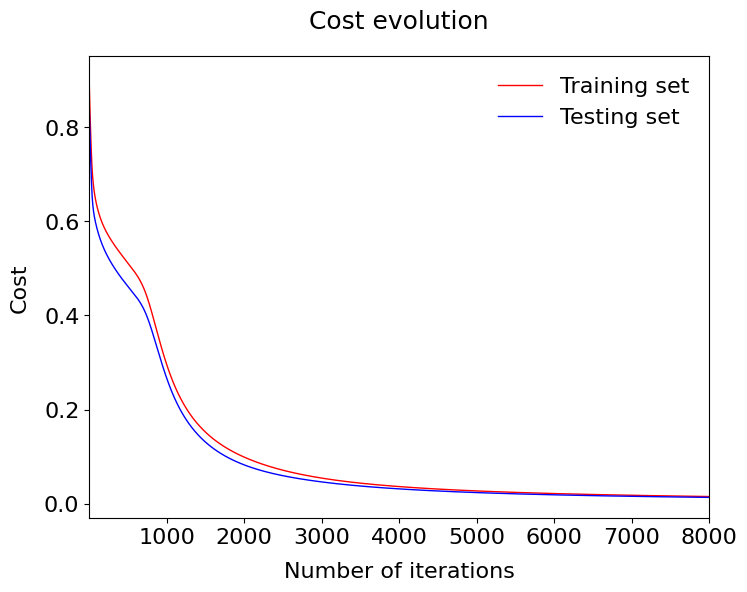

In [ ]:
# Train train train ! we will use the optimized parameters to plot the decision surface
weights,biases = Nnetwork.train(X_train,y_train,X_test,y_test,iterations=8000)

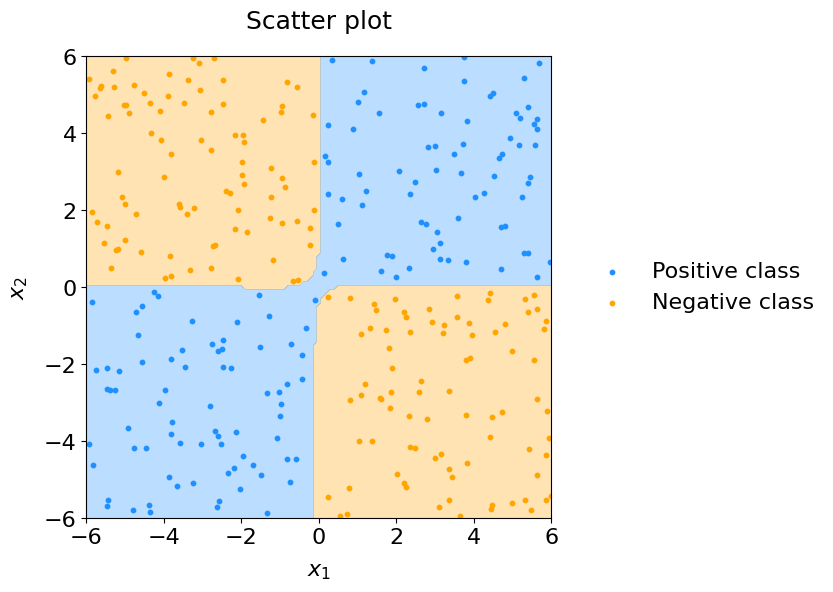

In [ ]:
# Yay ! we see the plot again !
ds = get_decision_surface(weights=weights,biases=biases)
plot_scatter(sig_train,bkg_train,ds=ds)